In [30]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
import tensorflow as tf

In [31]:
#Toto je zbytečný, ale fancy na larger projekty
#V Google Collab
data_dir = "content/Data/"

#Nadefinované labels dle dokumentace na Kagglu
disease_label = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Demented",
}

In [32]:
df_train = pd.read_parquet("/content/Data/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow") #loadujeme parquet dataset
df_test  = pd.read_parquet("/content/Data/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
df_test.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [33]:
row = df_train.iloc[0].values

In [34]:
#df_test/df_train jsou ve formátu slovníku obsahující jednotlivé bytes kvůli .parquet file type
def dict_to_image(image_dict): #přijímá argument slovníku -> df_test nebo df_train
    if isinstance(image_dict, dict) and 'bytes' in image_dict: #pokud je image_dict slovník a obsahuje binar. data z .parquet file
        byte_string = image_dict['bytes'] #binar data uložím
        nparr = np.frombuffer(byte_string, np.uint8) #převede binar data na array čísel (8 bit čísla)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE) #cv dekdoduje array, nahodí grayscale a vracíme img
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

df_train['img_arr'] = df_train['image'].apply(dict_to_image) #vytvoříme new sloupec
df_train.drop("image", axis=1, inplace=True)

df_test['img_arr'] = df_test['image'].apply(dict_to_image)
df_test.drop("image", axis=1, inplace=True)
df_train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [35]:
df_test.shape

(1280, 2)

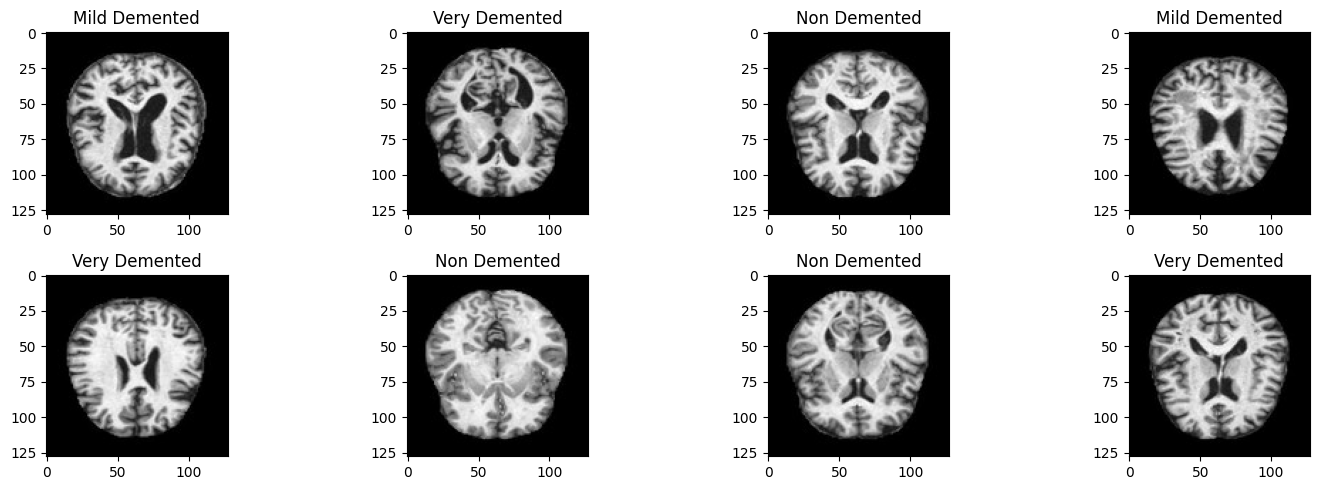

In [36]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df_test))
    axes.imshow(df_train.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label[df_train.iloc[rand]['label']])
plt.tight_layout()
plt.show()

Zakomentovaná Class BaselineCNN, pak to bude fakčit

In [37]:
N_CLASSES = df_train['label'].nunique()


# Use a torch dataset/dataloader to handle feeding our data in the model

# -------------- UPRAVENO ------------------------------------------------------
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):  # Add transform argument with default None
        self.dataframe = dataframe
        self.transform = transform  # Assign transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]

 # Převedení na Pillow Image
        image = Image.fromarray(image).convert('RGB')  # Převedení na RGB (3 kanály)

        # Použití transformací
        if self.transform:
            image = self.transform(image)

        # Převod štítku na tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label
class BaselineCNN(nn.Module):

    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.out = nn.Linear(128, N_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [38]:
# ---------- MODEL ------------------------------------------------------

learning_rate = 0.001
NEPOCHS = 12
batch_size = 32
train_losses = []

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AdvancedCNN, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
        for param in self.base_model.layer4.parameters():
            param.requires_grad = True

        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Data Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Převod na Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),  # Převod na Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Datasets and Dataloaders
image_datasets = {x: ImageDataset(df_train if x == 'train' else df_test,
                                  transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
              for x in ['train', 'val']}

# Model, Optimizer, Scheduler
model = AdvancedCNN()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = None
    best_loss = float('inf')
    ij = 1
    train_losses = [] # Initialize an empty list to store training losses

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                print(f'{ij}/{NEPOCHS}')
                ij = ij + 1
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss) # Append the epoch loss to the list

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, train_losses # Return the model and the list of training losses

"""
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = None
    best_loss = float('inf')
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
    model.load_state_dict(best_model_wts)
    return model
"""
# Train the model
model, train_losses = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=NEPOCHS)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/12
train Loss: 0.8608
val Loss: 0.8545
2/12
train Loss: 0.5943
val Loss: 0.8330
3/12
train Loss: 0.3992
val Loss: 0.5980
4/12
train Loss: 0.2455
val Loss: 0.2996
5/12
train Loss: 0.1504
val Loss: 0.3718
6/12
train Loss: 0.0821
val Loss: 0.3029
7/12
train Loss: 0.0515
val Loss: 0.2233
8/12
train Loss: 0.0279
val Loss: 0.1532
9/12
train Loss: 0.0107
val Loss: 0.1285
10/12
train Loss: 0.0121
val Loss: 0.1383
11/12
train Loss: 0.0084
val Loss: 0.1360
12/12
train Loss: 0.0125
val Loss: 0.1322


In [39]:
file_name = "AdvancedCNN_ResNet.pth"
save_path = os.path.join("content/Data", file_name)

torch.save(model.state_dict(), file_name)

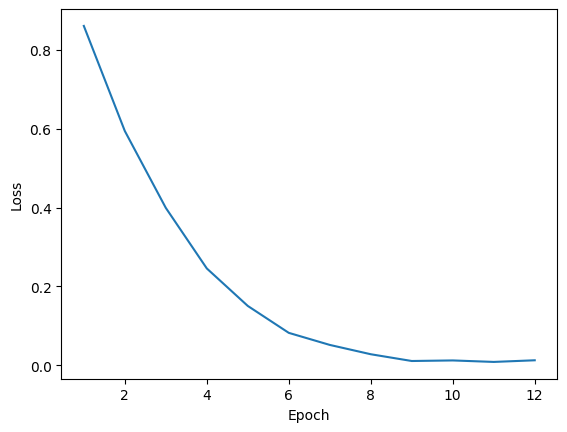

In [40]:
plt.plot(np.arange(1, len(train_losses) + 1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [41]:
train_dataset = ImageDataset(df_train, transform=data_transforms['train']) # Zde se používá transform
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def predict(m, dl, device): # -------- UPRAVENO ----------------------------------------------
    m.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in dl:
            images = images.to(device) # Move images to the same device as the model
            labels = labels.to(device) # Move labels to the same device as the model
            outputs = m(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

def result_summary(predictions, true_labels):
    # Accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #
predictions, true_labels = predict(model, train_loader, device)
result_summary(predictions, true_labels)

Accuracy: 0.9996
Confusion Matrix:
[[ 724    0    0    0]
 [   0   49    0    0]
 [   0    0 2565    1]
 [   0    0    1 1780]]
